In [1]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2
from warnings import simplefilter 
# import Utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils
import re
from Constants import Const

import pycausal
from pycausal import search, prior

import pydot
from IPython.display import SVG
from graphviz import Digraph

from scipy.stats import fisher_exact

simplefilter(action='ignore')
pd.set_option('display.max_rows', 1000)

In [53]:
df = pd.read_csv(Const.data_dir + 'cluster_stuff.csv')
good_cols = []
symptoms = ['pain','voice','teeth','choke','drymouth','mucus','mucositis','taste','numb']
for c in df.columns:
    if 'symptom' in c and not np.any([s in c for s in symptoms + ['cluster']]):
        continue
    if len(c) > 50:
        continue
#     if 'change' in c:
#         continue
    good_cols.append(c)
df = df[good_cols]
binary_df = pd.concat([pd.get_dummies(df[c],prefix=c) for c in df.columns],axis=1)
binary_df = binary_df[[c for c in binary_df.columns if ('_0' not in c)]]
for c in binary_df.columns:
    if 'cluster' not in c and '_1' in c:
        severe = c.replace('_1','_2')
        if severe in binary_df.columns:
            binary_df[c] = (binary_df[c] + binary_df[severe] > 0).astype(int)
binary_df.mean()

symptom_clusters_1                    0.209169
symptom_clusters_2                    0.243553
symptom_clusters_3                    0.108883
symptom_clusters_4                    0.335244
digest_increase_1                     0.020057
t4_1                                  0.097421
swallow_dose_clusters_1               0.031519
swallow_dose_clusters_2               0.343840
swallow_dose_clusters_3               0.338109
upper_mouth_dose_clusters_1           0.472779
upper_mouth_dose_clusters_2           0.315186
upper_mouth_dose_clusters_3           0.163324
lower_mouth_dose_clusters_1           0.280802
lower_mouth_dose_clusters_2           0.189112
lower_mouth_dose_clusters_3           0.355301
chew_dose_clusters_1                  0.223496
chew_dose_clusters_2                  0.243553
chew_dose_clusters_3                  0.014327
throat_dose_clusters_1                0.051576
throat_dose_clusters_2                0.435530
throat_dose_clusters_3                0.146132
shoulders_dos

In [22]:
def get_constraints(columns,forbid=None,require=None):
    if forbid is None:
        forbid = []
    if require is None:
        require= []
    truncate = lambda x: re.sub('\_\d','',x)
    for c in columns:
        for c2 in columns:
            if 'symptom' in c and 'symptom' in c2:
                forbid.append([c,c2])
#             if 'symptom_cluster' in c:
#                 forbid.append([c,c2])
#             if 'treatment' in c and 'treatment' in c2:
#                 forbid.append([c,c2])
            if 'baseline' in c and 'dose' not in c2:
                forbid.append([c,c2])
            if 'dose' in c and 'baseline_' in c2:
                forbid.append([c,c2])
            if truncate(c) == truncate(c2):
                forbid.append([c,c2])
            if 'post' in c:# and 'post' not in c2:
                forbid.append([c,c2])
            if 'dose' in c2 and 'dose' not in c:
                forbid.append([c,c2])
            if 't4' in c:
                forbid.append([c2,c])
    return forbid, require

def print_graph(tetrad=None,
                edgedict=None,
               ):
    assert(tetrad is not None or edgedict is not None)
    if edgedict is None:
        edgedict = get_edge_dict(tetrad)
    gviz = Digraph('G',engine='dot',format='png')
    edgedict = {k:v for k,v in edgedict.items()}# if  np.any(['dose' in vv or 't4' in vv for vv in v])}
    all_nodes = set(edgedict.keys())
    for k,v in edgedict.items():
        for item in v:
            all_nodes.add(item)
    clean = lambda x: x.replace('symptoms_','').replace('max_','').replace('_dose_clusters','\ndose_clust').replace('_treatment','\ntreat').replace('_post','\npost')
    for node in all_nodes:
        color='red'
        if 'dose' not in node:
            if 'cluster' in node:
                color = 'magenta'
            elif 'treat' in node:
                if '_1' in node:
                    color = 'lightgreen'
                else:
                    color = 'green'
            elif 't4' in node:
                color ='darkgrey'
            elif '_1' in node and 'digest' not in node:
                color = 'lightblue'
            else:
                color = 'blue'
        elif 'baseline' in node:
            color = 'grey'
#         node = node.replace('symptoms_','').replace('max_','')
        gviz.node(clean(node),style='filled',color=color)
    for node,parents in edgedict.items():
        for parent in parents:
            gviz.edge(clean(parent),clean(node))
    gviz = gviz.unflatten(stagger=5)
    return gviz

def dir_edge(edge,clean_text=True):
    target = re.sub('[a-zA-Z_0-9]*\s*--[>\-]','',edge).strip()
    source = re.sub('--[>\-]\s*[a-zA-Z_0-9]*','',edge).strip()
    if clean_text:
        clean = lambda x: x.replace('symptoms_','').replace('max_','').replace('_dose_clusters','\ndose_clust').replace('_treatment','\ntreat').replace('_post','\npost')
        target = clean(target)
        source = clean(source)
    return source,target

def get_edge_dict(graph = None,edgelist= None,clean_text=True):
    edgedict = {}
    assert(edgelist is not None or graph is not None)
    if edgelist is None:
        edgelist = graph.getEdges()
    for edge in edgelist:
        edge = re.sub('\[.*','',edge)
        source,target = dir_edge(edge,clean_text=clean_text)
#         if ('post' in target or 'treat' in target) and '_1' in target:
#             continue
        curredge = edgedict.get(target,[])
        curredge.append(source)
        edgedict[target] = curredge
    return edgedict

get_constraints(binary_df.columns)

([['symptom_clusters_0', 'symptom_clusters_0'],
  ['symptom_clusters_0', 'symptom_clusters_0'],
  ['symptom_clusters_0', 'symptom_clusters_1'],
  ['symptom_clusters_0', 'symptom_clusters_1'],
  ['symptom_clusters_0', 'symptom_clusters_2'],
  ['symptom_clusters_0', 'symptom_clusters_2'],
  ['symptom_clusters_0', 'symptom_clusters_3'],
  ['symptom_clusters_0', 'symptom_clusters_3'],
  ['symptom_clusters_0', 'symptom_clusters_4'],
  ['symptom_clusters_0', 'symptom_clusters_4'],
  ['symptom_clusters_0', 'swallow_dose_clusters_0'],
  ['symptom_clusters_0', 'swallow_dose_clusters_1'],
  ['symptom_clusters_0', 'swallow_dose_clusters_2'],
  ['symptom_clusters_0', 'swallow_dose_clusters_3'],
  ['symptom_clusters_0', 'upper_mouth_dose_clusters_0'],
  ['symptom_clusters_0', 'upper_mouth_dose_clusters_1'],
  ['symptom_clusters_0', 'upper_mouth_dose_clusters_2'],
  ['symptom_clusters_0', 'upper_mouth_dose_clusters_3'],
  ['symptom_clusters_0', 'lower_mouth_dose_clusters_0'],
  ['symptom_clusters_0'

In [4]:
pc = pycausal.pycausal.pycausal()
pc.start_vm()

symptom_clusters_1 --- symptom_clusters_2 because it was forbidden by background knowledge.
symptom_clusters_1 --- symptom_clusters_3 because it was forbidden by background knowledge.
symptom_clusters_1 --- symptom_clusters_4 because it was forbidden by background knowledge.
symptom_clusters_1 --- symptoms_choke_max_treatment_1 because it was forbidden by background knowledge.
symptom_clusters_1 --- symptoms_choke_max_treatment_2 because it was forbidden by background knowledge.
symptom_clusters_1 --- symptoms_choke_max_post_1 because it was forbidden by background knowledge.
symptom_clusters_1 --- symptoms_choke_max_post_2 because it was forbidden by background knowledge.
symptom_clusters_1 --- symptoms_drymouth_max_treatment_2 because it was forbidden by background knowledge.
symptom_clusters_1 --- symptoms_drymouth_max_post_1 because it was forbidden by background knowledge.
symptom_clusters_1 --- symptoms_drymouth_max_post_2 because it was forbidden by background knowledge.
symptom

['swallow_dose_clusters_3 --> symptoms_voice_max_treatment_2', 'throat_dose_clusters_3 --> symptoms_pain_max_treatment_2', 'upper_mouth_dose_clusters_3 --> symptoms_teeth_max_post_1', 'throat_dose_clusters_3 --> symptoms_mucus_max_post_1', 'throat_dose_clusters_3 --> symptoms_voice_max_post_1', 'shoulders_dose_clusters_1 --> symptoms_mucositis_max_treatment_2', 'upper_mouth_dose_clusters_2 --> symptoms_pain_max_treatment_2', 'upper_mouth_dose_clusters_3 --> symptoms_mucositis_max_post_1', 'upper_mouth_dose_clusters_1 --> symptoms_mucositis_max_treatment_1', 'shoulders_dose_clusters_1 --> symptoms_numb_max_treatment_2', 'throat_dose_clusters_1 --> symptoms_choke_max_post_2', 'throat_dose_clusters_3 --> symptoms_voice_max_treatment_1', 'throat_dose_clusters_3 --> symptoms_mucus_max_post_2', 'throat_dose_clusters_1 --> symptoms_choke_max_post_1']


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening '../data/structure_learning_bayes_graph.png'


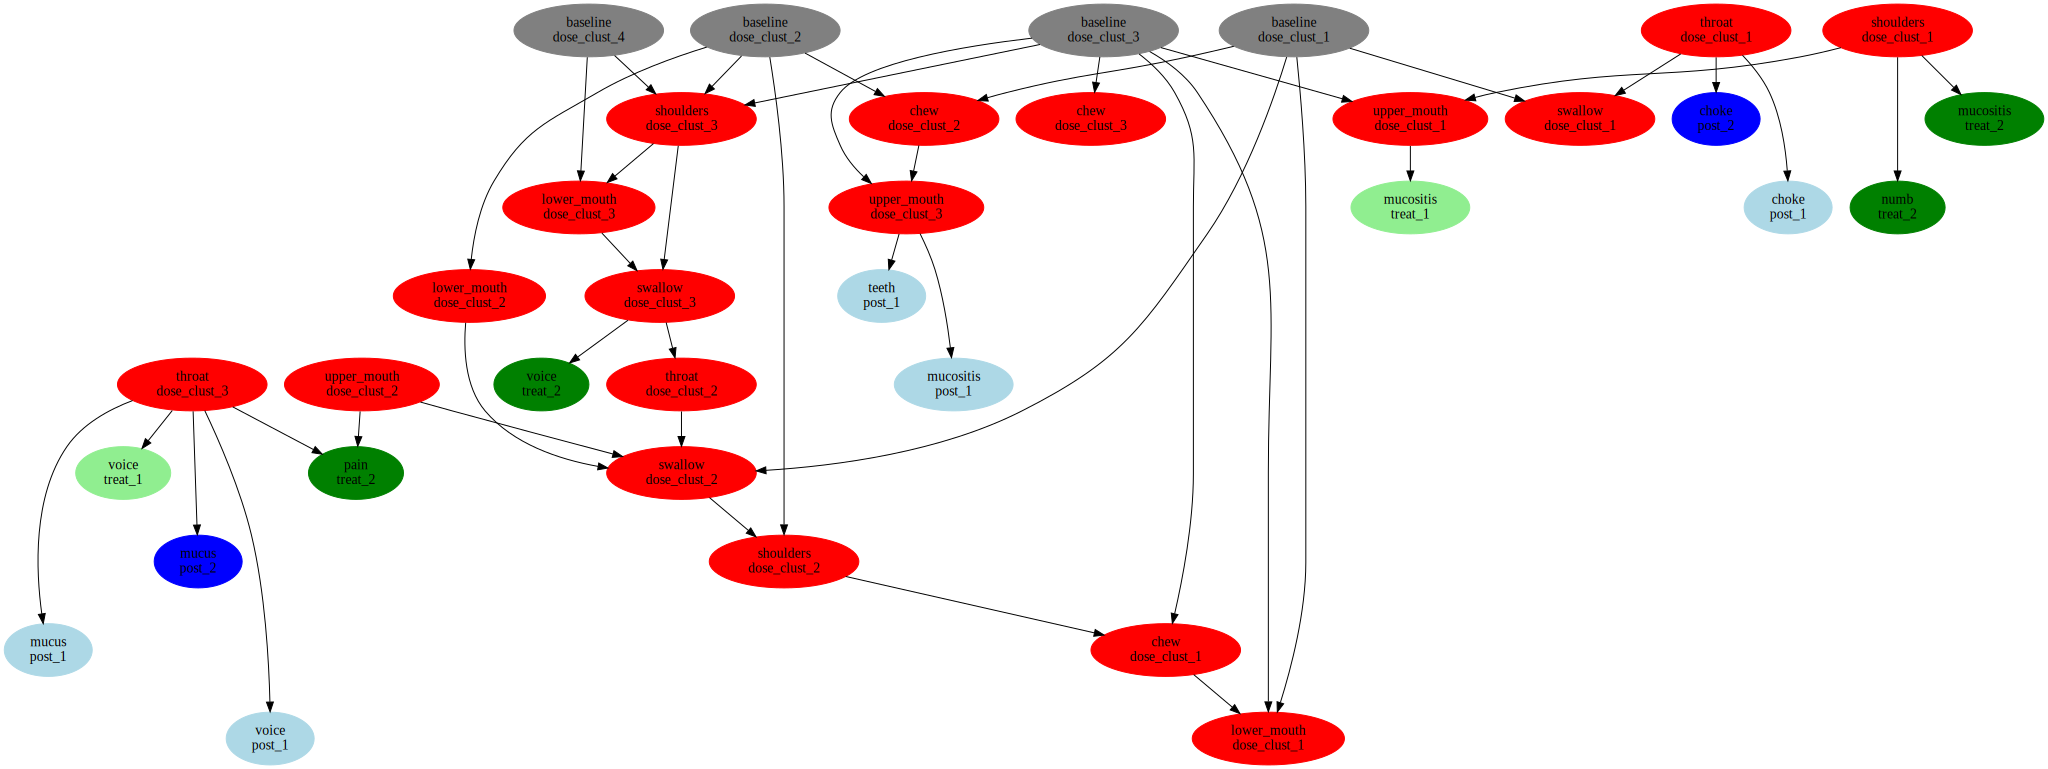

In [26]:
def run_bayesnet(df,alpha=.05):
    forbid,require = get_constraints(df.columns)
    p = prior.knowledge(forbiddirect=forbid,requiredirect=require)
    bayes = search.bayesEst(
        df,
        priorKnowledge=p,
        verbose=0,
        depth=-1,
        alpha=.05,
    )
    print([re.sub('\[.*\]\:','',c) for c in bayes.getEdges() if 'dose' in c and ('symptom' in c or 'digest' in c)])
    return bayes

bayes= run_bayesnet(binary_df.drop([c for c in binary_df.columns if 't4' in c],axis=1))
bayes_graph = print_graph(edgedict=get_edge_dict(bayes))
bayes_graph.view('structure_learning_bayes_graph',directory=Const.data_dir)
bayes_graph

testing swallow_dose_clusters_3 --> symptoms_voice_max_treatment_1 pval: 0.0 odds_ratio 2.423 size 118
testing upper_mouth_dose_clusters_3 --> digest_increase_1 pval: 0.015 odds_ratio 7.27 size 57
testing swallow_dose_clusters_3 --> symptoms_pain_max_treatment_2 pval: 0.013 odds_ratio 1.958 size 118
testing throat_dose_clusters_2 --> symptoms_numb_max_treatment_2 pval: 0.011 odds_ratio 0.377 size 152
testing throat_dose_clusters_3 --> symptoms_teeth_max_treatment_1 pval: 0.01 odds_ratio 2.277 size 51
testing lower_mouth_dose_clusters_1 --> symptoms_voice_max_post_1 pval: 0.009 odds_ratio 0.441 size 98
testing throat_dose_clusters_3 --> symptoms_mucus_max_treatment_1 pval: 0.017 odds_ratio 7.529 size 51
testing upper_mouth_dose_clusters_2 --> symptoms_pain_max_treatment_2 pval: 0.011 odds_ratio 0.531 size 110
testing throat_dose_clusters_3 --> symptoms_mucus_max_post_2 pval: 0.001 odds_ratio 2.76 size 51
testing lower_mouth_dose_clusters_3 --> symptoms_choke_max_post_1 pval: 0.001 odds_

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening '../data/structure_learning_graph_alt.png'


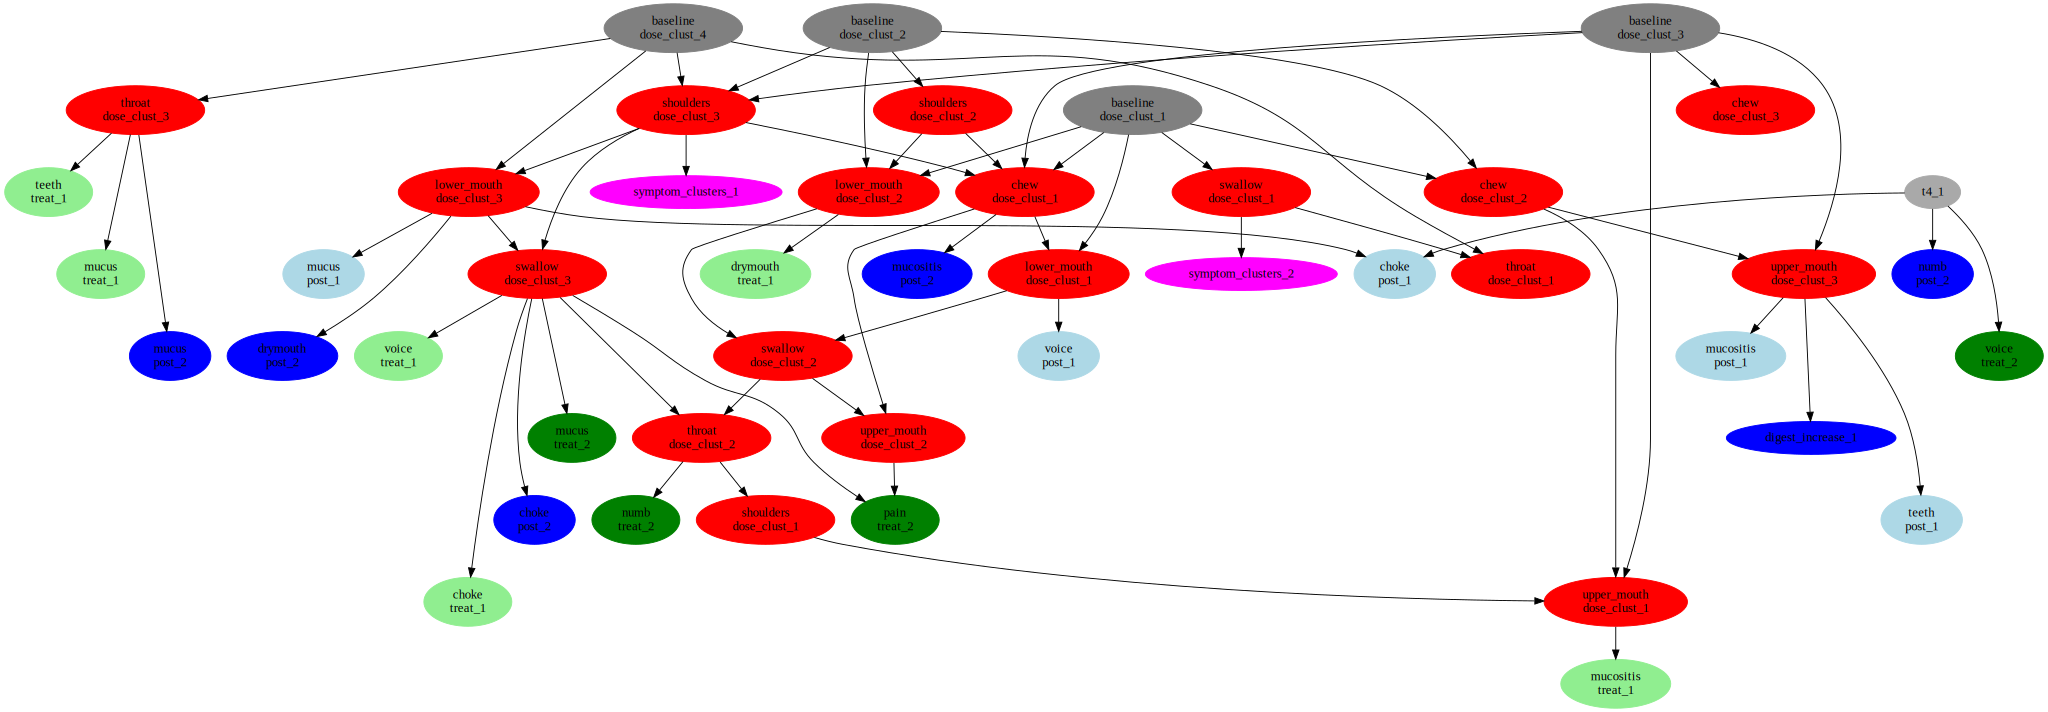

In [31]:
def contingency(v1,v2):
    n_v1 = len(np.unique(v1))
    n_v2 = len(np.unique(v2))
    table = np.zeros((n_v1,n_v2))
    for i, vv1 in enumerate(np.unique(v1)):
        for ii,vv2 in enumerate(np.unique(v2)):
            in_cell = (v1 == vv1) & (v2 == vv2)
            table[i,ii] = in_cell.sum()
    return table

def boolean_fisher_exact(v1,v2):
    ctable = contingency(v1,v2)
    return fisher_exact(ctable)

def run_tetrad_bootstrap(input_df,
                         n_iters = 10,
                         algoId='fges',
                         testId='fisher-z-test',
                         scoreId='disc-bic-score',
                         pct_threshold = .5,
                         pval_threshold=.017,
                         **kwargs):
    forbid,require = get_constraints(input_df.columns)
    p = prior.knowledge(forbiddirect=forbid,requiredirect=require)
    tetrad = search.tetradrunner()
    edgecounts = {}
    for i in range(n_iters):
        if n_iters > 1:
            temp_df = input_df.astype(int).sample(frac=1)
        else:
            temp_df = input_df.astype(int).copy()
        datatype = 'discrete' if algoId != 'imgs_cont' else 'continuous'
        tetrad.run(
                algoId = algoId,
                dfs=temp_df,
            verbose=False,
            priorKnowledge=p,
           testId = testId,
            scoreId=scoreId,
           dataType=datatype,
                  )
        edges = tetrad.getEdges()
        for e in edges:
            currcount = edgecounts.get(e,0)
            edgecounts[e] = currcount + 1
    good_edges = []
    for k,v in edgecounts.items():
        counts = v/n_iters
        if pval_threshold < 1 and pval_threshold is not None:
            xcol,ycol = dir_edge(k,clean_text=False)
            x = input_df[xcol]
            y = input_df[ycol]
            odds_ratio,pval = boolean_fisher_exact(x,y)
            if 'dose' in k and ('symptom' in k or 'digest' in k):
                print('testing',k,'pval:',np.round(pval,3),'odds_ratio',np.round(odds_ratio,3),'size',x.sum())
            if pval > pval_threshold:
                continue
        if counts > pct_threshold:
            good_edges.append(k)
    return get_edge_dict(edgelist=good_edges,clean_text=False)

test_edgedict = run_tetrad_bootstrap(binary_df,
#                                      algoId='imgs_cont',
                                     scoreId='mvp-bic-score',
                                     n_iters=1,
                                    )
graph = print_graph(edgedict=test_edgedict)
graph.view('structure_learning_graph_alt',directory=Const.data_dir)
graph

DecisionTreeClassifier(ccp_alpha=0.01, class_weight='balanced', max_depth=2,
                       min_samples_leaf=15)

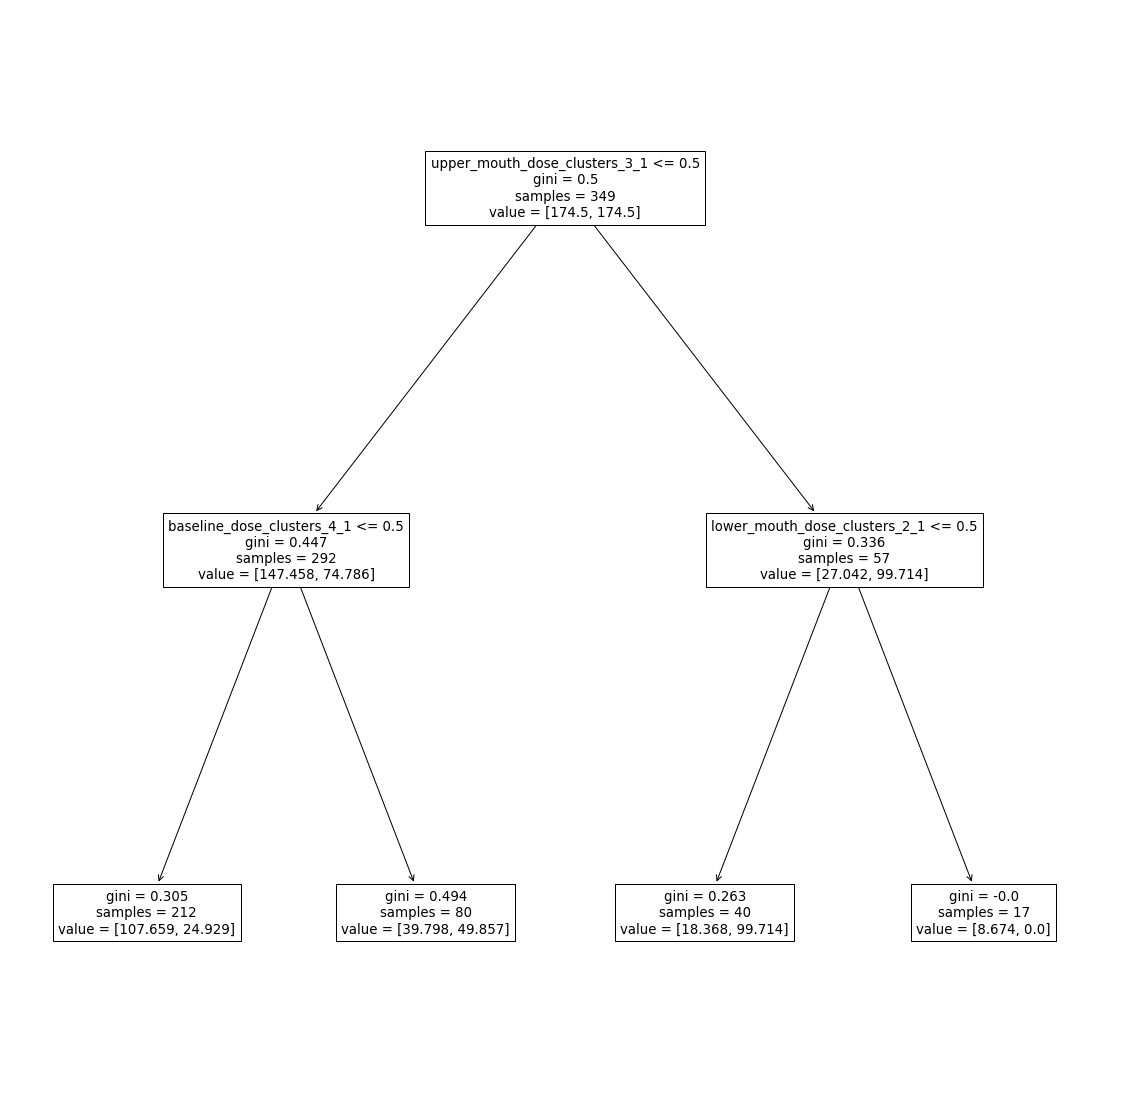

In [54]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

def search_df_thresholds(df,
                         outcome='digest_increase_1',
                         ax=None,
                         min_samples_leaf=15,
                         max_depth = 2,
                         balanced=True,
                         class_names=None,
                        ):
    bdf = pd.concat([pd.get_dummies(df[c],prefix=c) for c in df.columns],axis=1)
    x = bdf[[c for c in bdf.columns if 'dose_cluster' in c and '_0' not in c]]
    y = df[outcome].astype('bool')
    clf = DecisionTreeClassifier(
        ccp_alpha=.01,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced' if balanced else None,
        max_depth=max_depth).fit(x,y)
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(20,20))
    plot_tree(clf,ax=ax,class_names=class_names,feature_names=x.columns)
    return clf

search_df_thresholds(binary_df,
#                      balanced=True,
                    )

In [ ]:
# pc.stop_vm()